In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
import transformers
from transformers import AutoModelForTokenClassification, AutoTokenizer, AutoModel
from datasets import load_dataset
import torch
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import logging
from torch.utils.data import DataLoader, Dataset
from torcheval.metrics.functional import multiclass_f1_score, multiclass_confusion_matrix
from copy import deepcopy
from IPython.display import clear_output
from huggingface_hub import notebook_login
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import f1_score, confusion_matrix
import pandas as pd
import seaborn as sns

import os 
while 'notebooks' in os.getcwd():
    os.chdir("..")
    
from src.preprocessing.make_dataset import ImageLayoutDataset
from src.model.container.auxiliary_functions import F_mean, F_cov
from src.model.container.trainer import ContainerTrainer
import warnings
warnings.filterwarnings("ignore")

In [3]:
notebook_login()

In [4]:
!mkdir logs

mkdir: cannot create directory ‘logs’: File exists


In [5]:
device = "cuda" if torch.cuda.is_available() else 'cpu'
model_name = "few_shot_learning"
dataset_name = "sroie"

In [6]:
logging.basicConfig(filename='logs/few_shot_learning_cord.log', encoding='utf-8', level= logging.INFO)

## Importing source and support dataset

In [7]:
source_dataset = load_dataset(
    "darentang/sroie",
    cache_dir = "/Data/pedro.silva/"
)

support_dataset = load_dataset(
    "nielsr/funsd",
    cache_dir = "/Data/pedro.silva/"
)

In [8]:
model = AutoModel.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
).to(device)

tokenizer = AutoTokenizer.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
)

In [31]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [32]:
valid_labels ={
    0: 0,
    1: 1,
    2: 1,
    3: 2,
    4: 2,
    5: 3,
    6: 3,
    7: 4,
    8: 4
}

label_names= ['None', 'Header', 'Question', 'Answer']

source_df = ImageLayoutDataset(
    source_dataset['train'],
    tokenizer,
    valid_labels_keymap= valid_labels
)

  0%|          | 0/626 [00:00<?, ?it/s]

100%|██████████| 626/626 [00:03<00:00, 182.51it/s]


In [11]:
input = source_df[0]

In [12]:
out = model(
    input_ids=input['input_ids'].reshape(1,-1), 
    bbox= input['bbox'].reshape([1, 512, 4]),
    attention_mask=input['attention_mask'].reshape(1,-1), 
    token_type_ids=input['token_type_ids'].reshape(1,-1),
)

In [13]:
out.last_hidden_state.shape

torch.Size([1, 512, 768])

In [15]:
input_dim = 768
output_dim = 64
hidden_size = 128

f_mean = F_mean(
    input_dim,
    output_dim,
    hidden_size,
)

f_cov = F_cov(
    input_dim,
    output_dim,
    hidden_size
)

In [15]:
out.last_hidden_state[:,0, :].shape

torch.Size([1, 768])

In [16]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer = torch.optim.Adam(
    params,
    lr = 1e-4
)

## Train on source set

In [18]:
checkpoint_f_mean = "/Data/pedro.silva/f_mean_sroie-b.pt"
checkpoint_f_cov = "/Data/pedro.silva/f_cov_sroie-b.pt"
checkpoint_llm = "peulsilva/container-source-sroie-checkpoint-b"

In [19]:
trainer = ContainerTrainer(
    model,
    f_mean,
    f_cov,
    optimizer,
    checkpoint_llm,
    checkpoint_f_mean,
    checkpoint_f_cov
)

In [20]:
trainer.train_on_source_set(
    source_df,
    save = True,
    num_batches=20
)

batch 19
loss: 0.07122301310300827


model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

## Few shot learning on support domain - 2 shots

In [21]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [22]:
n_shots = 2
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3
}

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

  8%|▊         | 12/149 [00:00<00:01, 115.57it/s]

100%|██████████| 149/149 [00:01<00:00, 147.62it/s]


In [27]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [28]:
loss_prev = torch.inf
loss_ft = 1e100
loss_ft < loss_prev

True

In [23]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 149.07it/s]


In [24]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=2
)

epoch 9
loss: 0.047650087624788284


running validation


100%|██████████| 100/100 [00:03<00:00, 29.43it/s]


f1: 0.6316491650886555
[[   70   247   183  3421]
 [   25   534   294   389]
 [   26   235  3761  3170]
 [   35   312   222 10312]]


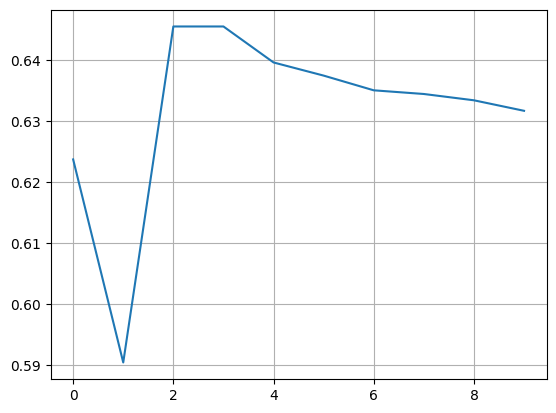

In [25]:
plt.plot(history)
plt.grid()

## Evaluation

In [26]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 129.98it/s]


In [33]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    n_shots=2
)

  0%|          | 0/2 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 28.85it/s]


In [34]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [35]:
f1

0.5550035486160397

Text(0.5, 1.0, 'Performance - FUNSD - 2 shots')

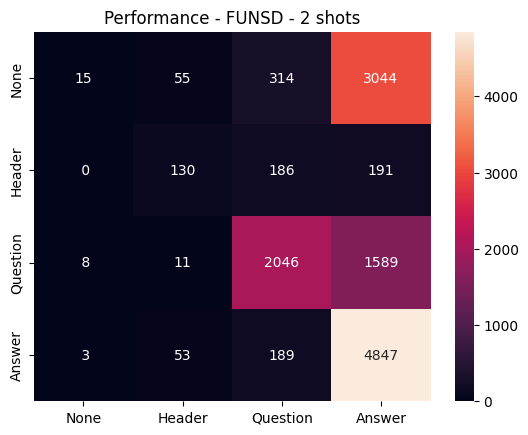

In [36]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 2 shots")

## Few shot learning on support domain - 5 shots

In [37]:
support_dataset['train'].features['ner_tags'].feature.names

['O',
 'B-HEADER',
 'I-HEADER',
 'B-QUESTION',
 'I-QUESTION',
 'B-ANSWER',
 'I-ANSWER']

In [38]:
n_shots = 5
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3
}

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 149/149 [00:00<00:00, 156.76it/s]


In [39]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [40]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 150.42it/s]


In [41]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=5
)

epoch 9
loss: 0.053883086889982224
running validation


100%|██████████| 100/100 [00:03<00:00, 29.73it/s]


f1: 0.6252598752598753
[[ 124  285  349 3166]
 [  35  575  329  296]
 [  43  178 4100 3016]
 [  35  351  569 9637]]


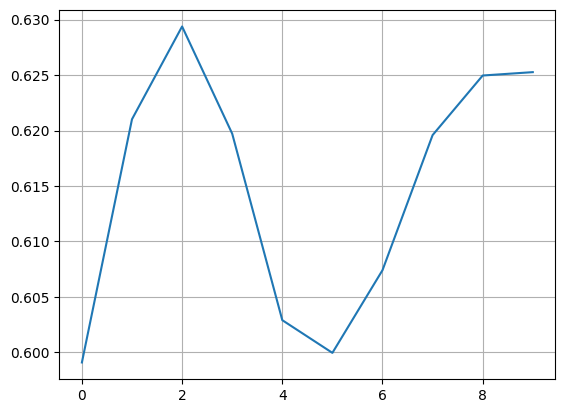

In [42]:
plt.plot(history)
plt.grid()

## Evaluation

In [43]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:00<00:00, 127.54it/s]


In [47]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    n_shots=5
)

  0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 28.91it/s]


In [48]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [49]:
f1

0.5591041715953

Text(0.5, 1.0, 'Performance - FUNSD - 2 shots')

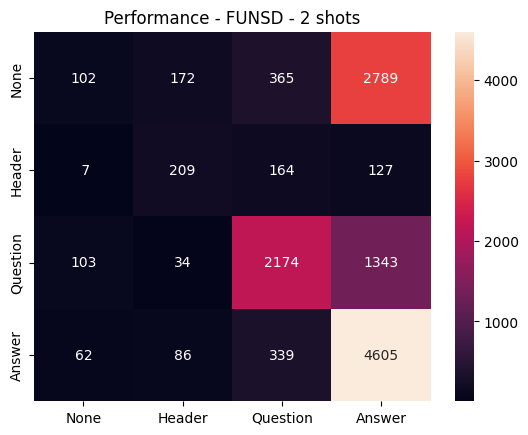

In [50]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 2 shots")

## Few shot learning on support domain - 10 shots

In [51]:
n_shots = 10
valid_labels_funsd = {
    0: 0,
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3
}

support_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 149/149 [00:00<00:00, 155.13it/s]


In [52]:
params = list(f_mean.parameters()) + list(f_cov.parameters()) + list(model.parameters())
optimizer_support = torch.optim.Adam(
    params,
    lr = 1e-4
)

In [53]:
val_df = ImageLayoutDataset(
    support_dataset['train'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

  0%|          | 0/149 [00:00<?, ?it/s]

100%|██████████| 149/149 [00:00<00:00, 156.31it/s]


In [54]:
history = trainer.train_on_support_set(
    support_df,
    val_df,
    n_shots=10
)

epoch 6
loss: 0.05275895446538925
running validation


100%|██████████| 100/100 [00:03<00:00, 29.46it/s]


f1: 0.6236912693605607
[[ 632  317  175 2633]
 [  56  611  319  261]
 [ 289  243 3795 3235]
 [ 257  606  307 9378]]


  0%|          | 0/10 [00:10<?, ?it/s]


KeyboardInterrupt: 

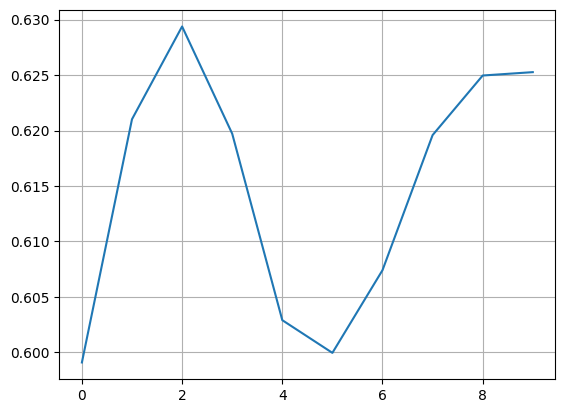

In [ ]:
plt.plot(history)
plt.grid()

## Evaluation

In [55]:
test_df = ImageLayoutDataset(
    support_dataset['test'],
    tokenizer,
    tokenize_all_labels=True,
    valid_labels_keymap=valid_labels_funsd
)

100%|██████████| 50/50 [00:00<00:00, 129.49it/s]


In [56]:
y_true, y_pred = trainer.test(
    support_df,
    test_df,
    n_shots=10
)

  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 28.62it/s]


In [57]:
f1= f1_score(y_true, y_pred, average='micro')
conf_matrix = confusion_matrix(y_true, y_pred)

In [58]:
f1

0.6022395710117499

Text(0.5, 1.0, 'Performance - FUNSD - 5 shots')

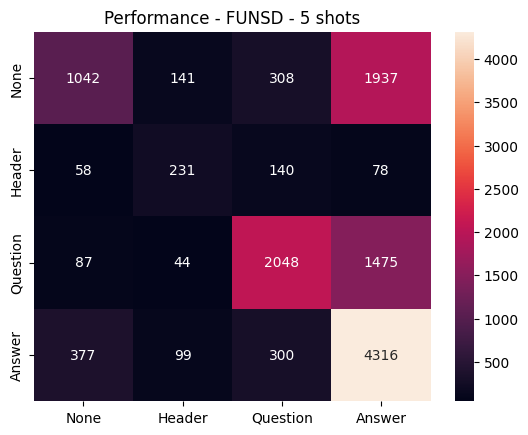

In [ ]:
df = pd.DataFrame(
    conf_matrix,
    index = list(label_names),
    columns=list(label_names)
)

sns.heatmap(
    df,
    annot = True,
    fmt = '2g',
)

plt.title("Performance - FUNSD - 5 shots")

## Results analysis - comparison with base model

In [60]:
base_model = AutoModel.from_pretrained(
    "microsoft/layoutlm-base-uncased",
    cache_dir = "/Data/pedro.silva/"
).to(device)

model = trainer.best_model

In [62]:
model.push_to_hub("peulsilva/funsd-container-10_shots")

model.safetensors:   0%|          | 0.00/451M [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/peulsilva/funsd-container-10_shots/commit/a6045026701fdd08aab9ba2ca863729025937eb8', commit_message='Upload model', commit_description='', oid='a6045026701fdd08aab9ba2ca863729025937eb8', pr_url=None, pr_revision=None, pr_num=None)

In [63]:
trained_vectors = []
base_vectors = []
labels = []

with torch.no_grad():
    for i in tqdm(range(len(test_df))):
        input = test_df[i]
        mask = input['labels'] != -100

        labels.append(
            input['labels'][mask]\
                .cpu()\
                .detach()\
                .numpy()
        )

        out1 = model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        trained_vectors.append(
            out1.last_hidden_state\
                [mask]\
                .cpu()\
                .detach()\
                .numpy()
        )

        out2 = base_model(
            input_ids=input['input_ids'].reshape(1,-1), 
            bbox= input['bbox'].reshape([1, 512, 4]),
            attention_mask=input['attention_mask'].reshape(1,-1), 
            token_type_ids=input['token_type_ids'].reshape(1,-1),
        )

        base_vectors.append(
            out2.last_hidden_state\
            [mask]\
            .cpu()\
            .detach()\
            .numpy()
        )

100%|██████████| 50/50 [00:01<00:00, 41.31it/s]


In [64]:
concat_base_vectors = np.concatenate(base_vectors)
concat_trained_vectors = np.concatenate(trained_vectors)
concat_labels = np.concatenate(labels)

In [66]:
pca = PCA(n_components=2)
x1 = pca.fit_transform(concat_trained_vectors)
x2 = pca.fit_transform(concat_base_vectors)

In [67]:
df1 = pd.DataFrame(x1)
df1['labels'] = concat_labels

df2 = pd.DataFrame(x2)
df2['labels'] = concat_labels

In [68]:
grouped_features1 = df1.groupby('labels').apply(lambda x: x.iloc[:, :-1].values)
grouped_features2 = df2.groupby('labels').apply(lambda x: x.iloc[:, :-1].values)

In [69]:
label_names

['None', 'Header', 'Question', 'Answer']

In [70]:
grouped_features1[0]

array([[-6.101086  ,  0.32151413],
       [-6.4193797 ,  0.7298398 ],
       [-5.296635  ,  0.08348922],
       ...,
       [-5.4374404 ,  1.3194182 ],
       [-4.923631  ,  2.5990915 ],
       [-4.200387  ,  0.45190766]], dtype=float32)

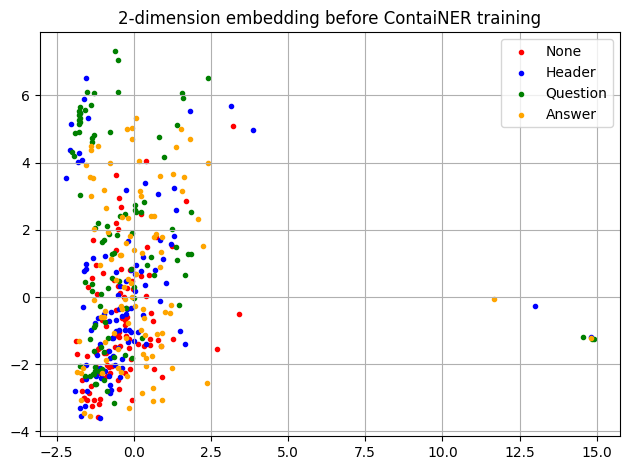

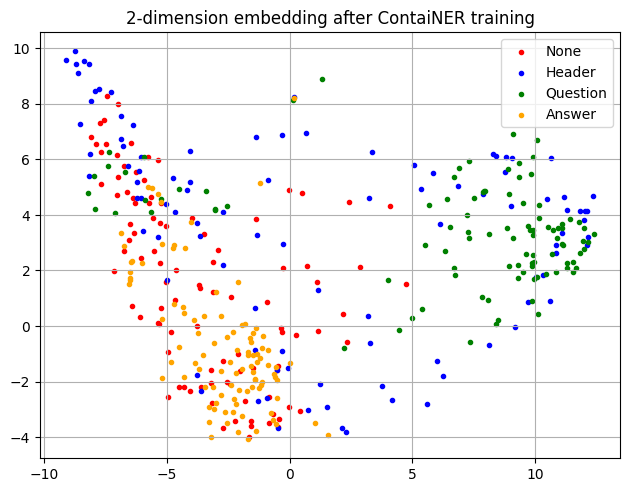

In [74]:
colors = ['red', 'blue', 'green', 'orange', 'purple']
num_classes = len(label_names)
num_shots = 100

for c in range(num_classes):    
    
    plt.scatter(
        grouped_features2[c][0:num_shots,0], 
        grouped_features2[c][0:num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = label_names[c]
    )

plt.legend()
plt.grid()
plt.title("2-dimension embedding before ContaiNER training")
plt.tight_layout()
plt.show()

for c in range(num_classes):    
    
    plt.scatter(
        grouped_features1[c][0:num_shots,0], 
        grouped_features1[c][0:num_shots, 1],        
        marker = '.',
        c = colors[c],
        label = label_names[c]
    )

plt.legend()
plt.grid()
plt.tight_layout()
plt.title("2-dimension embedding after ContaiNER training")
plt.show()
